In [9]:
import numpy as np
import colorsys
import h5py
from PIL import Image
import io
import matplotlib.pyplot as plt
import time
%matplotlib inline


In [74]:
def unproject_pixels(pts, depth, cam_matrix, vfov=55, near_plane=0.1, far_plane=100):
    '''
    pts: [N, 2] pixel coords
    depth: [N, ] depth values
    returns: [N, 3] world coords
    '''

    
    camera_matrix = np.linalg.inv(cam_matrix.reshape((4, 4)))

    # Different from real-world camera coordinate system.
    # OpenGL uses negative z axis as the camera front direction.
    # x axes are same, hence y axis is reversed as well.
    # Source: https://learnopengl.com/Getting-started/Camera
    rot = np.array([[1, 0, 0, 0],
                    [0, -1, 0, 0],
                    [0, 0, -1, 0],
                    [0, 0, 0, 1]])
    camera_matrix = np.dot(camera_matrix, rot)


    height = depth_map.shape[0]
    width = depth_map.shape[1]

    img_pixs = pts[:, [1, 0]].T
    img_pix_ones = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    vfov = vfov / 180.0 * np.pi
    tan_half_vfov = np.tan(vfov / 2.0)
    tan_half_hfov = tan_half_vfov * width / float(height)
    fx = width / 2.0 / tan_half_hfov  # focal length in pixel space
    fy = height / 2.0 / tan_half_vfov
    intrinsics = np.array([[fx, 0, width/ 2.0],
                           [0, fy, height / 2.0],
                           [0, 0, 1]])
    img_inv = np.linalg.inv(intrinsics[:3, :3])
    cam_img_mat = np.dot(img_inv, img_pix_ones)

    points_in_cam = np.multiply(cam_img_mat, depth.reshape(-1))
    points_in_cam = np.concatenate((points_in_cam, np.ones((1, points_in_cam.shape[1]))), axis=0)
    points_in_world = np.dot(camera_matrix, points_in_cam)
    points_in_world = points_in_world[:3, :].T#.reshape(3, height, width)
    points_in_cam = points_in_cam[:3, :].T#.reshape(3, height, width)
    
    return points_in_world

def pad_ones(pts):
    '''
    pts: [N , K]
    returns: [N, K+1]
    '''
    pw = np.concatenate([pts, np.ones([pts.shape[0], 1])], 1)
    return pw


def proj_world_to_pixel(pw, cam_matrix, proj_matrix):
    '''
    pw: [N, 3] world coords
    cam_matrix: [4, 4] cam matrix
    proj_matrix: [4, 4] proj matrix
    returns: [N, 2] pixel coords
    '''
    t = time.time()
    matrix = np.matmul(proj_matrix, cam_matrix)
    
    pw = pad_ones(pw).T
    
    proj_pts = np.matmul(matrix, pw).T
    
    depth = proj_pts[:, 3]

    proj_pts = proj_pts/proj_pts[:, 3:4]

    proj_pts = proj_pts.clip(-1, 1)


    proj_pts = (proj_pts + 1)/2
    
    proj_pts = proj_pts[:, :2]

    proj_pts[:, 1] = 1 - proj_pts[:, 1]

    proj_pts = proj_pts[:, [1, 0]]

    proj_pts = (proj_pts*512).astype(int)
    
    print("time:", time.time() - t)
    
    return proj_pts, depth

import numpy as np
import matplotlib.pyplot as plt

def get_square(center, num_points, rnge=1):
    '''
    center: [x, z, y]
    '''
    # Define the number of points along each side
    
    center_xy = center[[0, 2]]
    
    bnd = rnge/2

    # Create a grid of x and y values between -1 and 1
    x = np.linspace(-bnd, bnd, num=num_points)
    y = np.linspace(-bnd, bnd, num=num_points)
    X, Y = np.meshgrid(x, y)

    # Create a mask for the points inside the square
    mask = (X >= -1) & (X <= 1) & (Y >= -1) & (Y <= 1)

    # Select the points inside the square
    points = np.column_stack([X[mask], Y[mask]])
    
#     print(center_xy)
#     
    points = points + center_xy[None, :]
    
    points = pad_ones(points)
    
    points[:, 2] = center[1]
    
    points = points[:, [0, 2, 1]]
    
    return points


def random_point_in_triangle(v1, v2, v3):
    """Return a random point in the triangle defined by v1, v2, v3."""
    s, t = sorted([np.random.random(), np.random.random()])
    return (s * v1[0] + (t-s)*v2[0] + (1-t)*v3[0],
            s * v1[1] + (t-s)*v2[1] + (1-t)*v3[1])

def get_disc(center, num_points=1000, rnge=1):
    """Generate a point cloud for an upright triangular prism."""
    # Define vertices of the base triangle
    xc, yc, zc = center
    base_triangle = np.array([[xc, zc, yc], [xc+0.2, zc, yc], [xc, zc+0.2, yc]])

    # Define height of the prism
    height = 0.7

    # Generate points
    points = []
    for _ in range(num_points):
        base_point = random_point_in_triangle(*base_triangle)
        x = base_point[0]
        y = base_point[1]
        z = np.random.random() * height  # Random height
        
        points.append([x, y, z])

    return np.array(points)[:, [0, 2, 1]]



def sample_point_on_line_segment(v1, v2):
    """Return a random point on the line segment defined by v1 and v2."""
    t = np.random.random()
    return v1 + t * (v2 - v1)

def get_disc_edges(center, num_points=1000, rnge=1):
    """Generate a point cloud for the edges of an upright triangular prism."""
    # Define vertices of the base triangle
    xc, yc, zc = center
    base_triangle = np.array([[xc, zc, yc], [xc+0.2, zc, yc], [xc, zc+0.2, yc]])

    # Define height of the prism
    height = 0.7
    top_triangle = base_triangle + [0, 0, height]

    # Edges of the prism
    edges = [
        (base_triangle[0], base_triangle[1]),
        (base_triangle[1], base_triangle[2]),
        (base_triangle[2], base_triangle[0]),
        (top_triangle[0], top_triangle[1]),
        (top_triangle[1], top_triangle[2]),
        (top_triangle[2], top_triangle[0]),
        (base_triangle[0], top_triangle[0]),
        (base_triangle[1], top_triangle[1]),
        (base_triangle[2], top_triangle[2]),
    ]

    # Sample points along the edges
    points = []
    for edge in edges:
        for _ in range(num_points):
            point = sample_point_on_line_segment(edge[0], edge[1])
            points.append(point)

    return np.array(points)[:, [0, 2, 1]]



def filter_occluded(pts, im_seg, color, depth_map, depth_sq):
    '''
    pts: [N, 2] pixel coords
    returns: [K < N, 2] unoccluded coords
    '''

    target = (im_seg ==  color[None, None, :]).all(-1).astype('float')

    im_seg = (im_seg >0).any(-1).astype('float')

    im_seg = im_seg - target
    
    im_seg = im_seg > 0
    
    im_seg = ~im_seg
    
    valid = im_seg[pts[:, 0], pts[:, 1]]
    
    valid_depth = depth_map[pts[:, 0], pts[:, 1]] > depth_sq
        
    valid = valid | valid_depth
    
    return pts[valid], im_seg


**Get cam and proj matrices**

In [75]:
# file_path = '/ccn2/u/rmvenkat/data/testing_physion/gen_full_data_depth_512/lf_0/collide_all_movies/pilot_it2_collision_assorted_targets_box/0001.hdf5'

file_path = '/ccn2/u/rmvenkat/data/testing_physion/generate_all_physion_restarted_new/train_consolidated/lf_0/collide_all_movies/pilot_it2_collision_assorted_targets_tdw_1_dis_1_occ/0000.hdf5'

h5file = h5py.File(file_path, 'r')

cam_matrix = h5file['frames']['0000']['camera_matrices']['camera_matrix_cam0'][:]

cam_matrix = cam_matrix.reshape(4, 4)

proj_matrix = h5file['frames']['0000']['camera_matrices']['projection_matrix_cam0'][:]

proj_matrix = proj_matrix.reshape(4, 4)



**View image, segmentation colors and depth map**

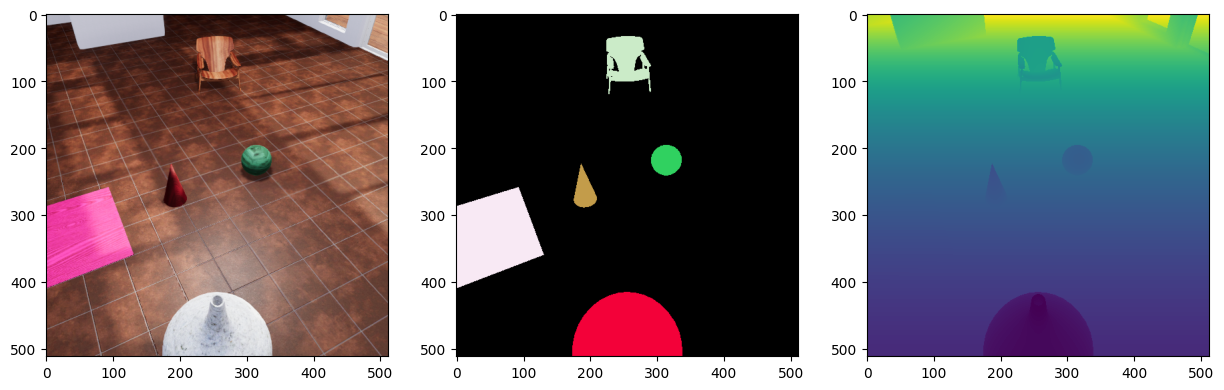

In [76]:
im = np.array(Image.open(io.BytesIO(h5file['frames']['0000']['images']['_img_cam0'][:])))

im_seg = np.array(Image.open(io.BytesIO(h5file['frames']['0000']['images']['_id_cam0'][:])))
colors = h5file['static']['object_segmentation_colors'][:][0]

depth_map = np.array(h5file['frames']['0000']['images']['_depth_cam0'])

fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot(131)
ax.imshow(im)

ax = fig.add_subplot(132)
ax.imshow(im_seg)

ax = fig.add_subplot(133)
ax.imshow(depth_map)

**Overlay disc**

time: 0.008807897567749023
time: 0.03418397903442383


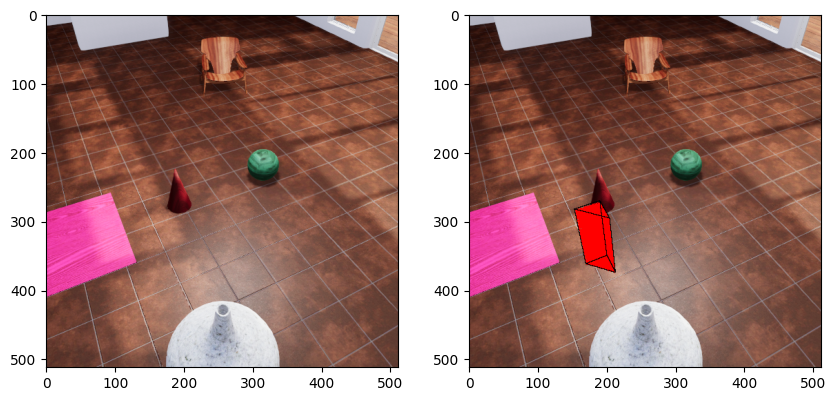

In [77]:
disc_radius = 0.2
x, y = 350, 200
num_samp =100000

im_cpy = im.copy()

pts = np.array([[x, y]])
depth = depth_map[pts[:, 0], pts[:, 1]]
pw = unproject_pixels(pts, depth, cam_matrix)

pw_square = get_disc(pw[0], num_samp, rnge=disc_radius)

pixel_coord_recon_square, depth_sq = proj_world_to_pixel(pw_square, cam_matrix, proj_matrix)

pixel_coord_recon_square_, valid_img = filter_occluded(pixel_coord_recon_square, im_seg, colors, depth_map, depth_sq)

for pt in pixel_coord_recon_square_:
    im_cpy[pt[0]:pt[0]+1, pt[1]:pt[1]+1] = [255, 0, 0]
    
    
pw_square = get_disc_edges(pw[0], num_samp, rnge=disc_radius)

pixel_coord_recon_square, depth_sq = proj_world_to_pixel(pw_square, cam_matrix, proj_matrix)

pixel_coord_recon_square_, valid_img = filter_occluded(pixel_coord_recon_square, im_seg, colors, depth_map, depth_sq)

for pt in pixel_coord_recon_square_:
    im_cpy[pt[0]:pt[0]+1, pt[1]:pt[1]+1] = [0, 0, 0]

fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(121)
ax.imshow(im)

ax = fig.add_subplot(122)
ax.imshow(im_cpy)